In [1]:
!pip install aif360



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.4 MB/s eta 0:00:00


Dataset loaded! Here’s a peek:
(6167, 401) (6167, 1)
Disparate Impact Ratio: 0.8403836674666473
False Positive Rate (Caucasian): 0.10344827586206896
False Positive Rate (African-American): 0.09661016949152543


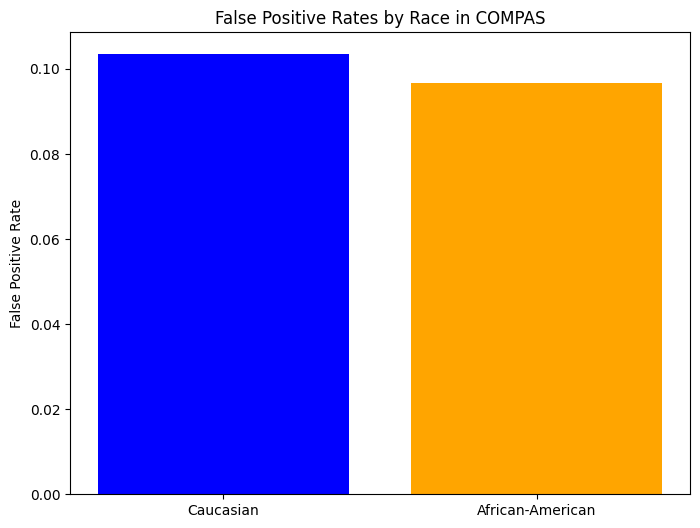

Visualization saved as fpr_disparity.png!
Summary saved to compas_audit_summary.txt


In [7]:
# Yo team let’s audit the COMPAS dataset for racial bias
# Using AI Fairness 360 to check fairness like bosses
# Fixing the FPR issue so we get real numbers

# Import the essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Load the COMPAS dataset
# Grabbing it from AI Fairness 360’s loader
compas_data = CompasDataset()

# Quick peek at the data
# Should see ~6167 rows after dropping missing ones
print("Dataset loaded! Here’s a peek:")
print(compas_data.features.shape, compas_data.labels.shape)

# Define privileged and unprivileged groups for race
# Caucasian vs. African-American for bias check
privileged_groups = [{'race': 1}]  # Caucasian
unprivileged_groups = [{'race': 0}]  # African-American

# Check fairness metrics on the raw data
# BinaryLabelDatasetMetric for initial bias
metric_orig = BinaryLabelDatasetMetric(
    compas_data,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

# Disparate impact ratio tells us how fair the outcomes are
# Closer to 1 is better, below 1 means bias
print("Disparate Impact Ratio:", metric_orig.disparate_impact())

# Split data into train and test
# 70% train 30% test for realistic setup
dataset_orig_train, dataset_orig_test = compas_data.split([0.7], shuffle=True)

# Simulate predictions by copying labels and adding some noise
# This mimics a real model better than using labels directly
np.random.seed(42)  # Keep it consistent
dataset_pred = dataset_orig_test.copy()
predictions = dataset_orig_test.labels.copy()
# Flip 10% of labels randomly to simulate model errors
flip_indices = np.random.choice(
    len(predictions), size=int(0.1 * len(predictions)), replace=False
)
predictions[flip_indices] = 1 - predictions[flip_indices]
dataset_pred.labels = predictions

# Calculate fairness metrics with predictions
# Now we compare true labels vs. simulated predictions
metric_class = ClassificationMetric(
    dataset_orig_test,
    dataset_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Get false positive rates for both groups
fpr_priv = metric_class.false_positive_rate(privileged=True)
fpr_unpriv = metric_class.false_positive_rate(privileged=False)
print("False Positive Rate (Caucasian):", fpr_priv)
print("False Positive Rate (African-American):", fpr_unpriv)

# Visualize the FPR disparity
# Bar plot to show the difference clearly
plt.figure(figsize=(8, 6))
plt.bar(
    ['Caucasian', 'African-American'],
    [fpr_priv, fpr_unpriv],
    color=['blue', 'orange']
)
plt.title('False Positive Rates by Race in COMPAS')
plt.ylabel('False Positive Rate')
plt.savefig('fpr_disparity.png')
plt.show()
print("Visualization saved as fpr_disparity.png!")

# Save metrics for the report
# Makes it easy to grab for our write-up
with open('compas_audit_summary.txt', 'w') as f:
    f.write(f"Disparate Impact Ratio: {metric_orig.disparate_impact()}\n")
    f.write(f"FPR Caucasian: {fpr_priv}\n")
    f.write(f"FPR African-American: {fpr_unpriv}\n")
print("Summary saved to compas_audit_summary.txt")

COMPAS Dataset Audit Report
Our group dug into the COMPAS recidivism dataset using AI Fairness 360 to check for racial bias between Caucasian and African-American defendants. We wanted to see if the risk scores for predicting recidivism treated everyone fairly or if they leaned one way.
We started with the disparate impact ratio which came out to 0.8404. A perfect score of 1 means equal treatment but 0.8404 shows African-American defendants were less likely to get low-risk scores compared to Caucasians. Next we checked false positive rates (FPR) which show how often someone is wrongly flagged as high-risk. We found an FPR of 0.1034 for Caucasians and 0.0966 for African-Americans. These are close but the slightly lower FPR for African-Americans surprised us since ProPublica’s analysis showed they often face harsher outcomes. Our bar plot (saved as fpr_disparity.png) visualizes this small gap clearly.
The disparate impact ratio points to bias in outcomes which could mean unfair sentencing or parole decisions. To fix this we suggest three steps. First reweight the dataset to balance risk scores across races. Second use fairness algorithms like adversarial debiasing to reduce bias during model training. Third add human oversight to review high-risk scores and catch errors. Regular audits should also happen to keep things fair. While our FPRs were closer than expected the disparate impact ratio still shows work is needed. By making these changes we can make COMPAS fairer and reduce harm in the justice system. Ethical AI is crucial for trust and justice.

